In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor

In [15]:
df = pd.read_parquet("processed_data/final_feature_engineered_retail_data.parquet")
df.shape

(421570, 26)

In [16]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Has_Markdown', 'Week',
       'Month', 'Year', 'Rolling_Mean_4', 'Rolling_Std_4', 'Z_Score',
       'Pct_Deviation', 'Lag_1', 'Type_B', 'Type_C'],
      dtype='object')

In [17]:
df.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1            0
MarkDown2            0
MarkDown3            0
MarkDown4            0
MarkDown5            0
CPI                  0
Unemployment         0
Size                 0
Has_Markdown         0
Week                 0
Month                0
Year                 0
Rolling_Mean_4       0
Rolling_Std_4        0
Z_Score           3499
Pct_Deviation        9
Lag_1                0
Type_B               0
Type_C               0
dtype: int64

Nans in the Z_Score column are due to the fact for each unique combination of Store and Dept,the first record will have a 0 standard deviation, which leads to a division by zero when calculating the Z_Score. This results in NaN values for the Z_Score in those cases.


9 nan values in the Pct_Deviation column. Missing Pct_Deviation values arise when the rolling baseline is undefined; these will be set to 0 to indicate absence of deviation. Replacing them with mean/median is not appropriate as it will introduce temporal leakage.

In [18]:
df[df["Pct_Deviation"].isnull()]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Has_Markdown,Week,Month,Year,Rolling_Mean_4,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C
6060,1,47,2011-08-19,0.0,0,89.94,3.554,0.0,0.0,0.0,0.0,0.0,215.669311,7.962,151315,0,33,8,2011,0.0,161.666323,0.0,NaN,0.0,False,False
17457,2,60,2010-03-19,0.0,0,54.52,2.720,0.0,0.0,0.0,0.0,0.0,210.873332,8.324,202307,0,11,3,2010,0.0,0.000000,NaN,NaN,0.0,False,False
56663,6,78,2010-02-26,0.0,0,47.10,2.561,0.0,0.0,0.0,0.0,0.0,212.845337,7.259,202505,0,8,2,2010,0.0,0.000000,NaN,NaN,0.0,False,False
93571,10,47,2010-02-19,0.0,0,58.22,2.915,0.0,0.0,0.0,0.0,0.0,126.526286,9.765,126512,0,7,2,2010,0.0,0.000000,NaN,NaN,0.0,True,False
95625,10,78,2011-09-30,0.0,0,82.27,3.877,0.0,0.0,0.0,0.0,0.0,129.606067,8.257,126512,0,39,9,2011,0.0,9.797959,0.0,NaN,-12.0,True,False
100253,11,19,2010-02-05,0.0,0,46.04,2.572,0.0,0.0,0.0,0.0,0.0,214.424881,7.368,207499,0,5,2,2010,0.0,0.000000,NaN,NaN,0.0,False,False
189748,20,19,2010-02-05,0.0,0,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187,203742,0,5,2,2010,0.0,0.000000,NaN,NaN,0.0,False,False
253763,26,60,2010-04-16,0.0,0,36.60,2.885,0.0,0.0,0.0,0.0,0.0,131.980900,8.512,152513,0,15,4,2010,0.0,0.000000,NaN,NaN,0.0,False,False
407652,44,27,2011-01-14,0.0,0,20.60,2.903,0.0,0.0,0.0,0.0,0.0,127.300935,7.224,39910,0,2,1,2011,0.0,0.000000,NaN,NaN,0.0,False,True


In [19]:
df["Pct_Deviation"] = df["Pct_Deviation"].fillna(0)

## Feature Selection for Anomaly Detection

Z Score feature will not be used for anomaly detection as it is basically an anomaly decision rule itself.Z Score already embeds an anomaly decision under normality assumptions,which leads to circular reasoning when used inside another anomaly detection model.

Pct_Deviation feature is a raw , scale-invariant behavioral signal that lets the anomaly model decide what is abnormal.This feature will be retained because it is a normalized behavioral signal not an anomaly decision rule.It provided context,while the model determines abnormality

Static Categorical Identifiers such as Store Type will be excluded because anomalies are temporal deviations in behavior, not differences between fixed categories.

Week , Month , Year : These are seasonality indicators.Useful for forecasting but not good for anomaly detection.The model might learn to associate certain weeks or months with anomalies due to seasonal patterns.Excluding these to prevent the model from treating seasonal periods as anomalous.

Store , Dept : These are static identifiers , not behavioral features.Including them would introduce artificial distance relationships.

Temperature is excluded due to weak direct influence on weekly sales (usually) relative to other stronger contextual features.
It is usually not a strong driver of sales unless your dataset is focused on weather-sensitive categories.Temperature affects only certain products but not the majority of weekly sales.

Markdown features are highly sparse,correlated and noisy.Instead of using them directly, we will use Has_Markdown which captures there presence effect , which matters more.

In [20]:
feature_cols = ["Weekly_Sales" , "IsHoliday" ,"Fuel_Price","CPI","Unemployment","Size","Has_Markdown","Rolling_Mean_4","Rolling_Std_4","Pct_Deviation","Lag_1"]

In [21]:
df[feature_cols].isnull().sum()

Weekly_Sales      0
IsHoliday         0
Fuel_Price        0
CPI               0
Unemployment      0
Size              0
Has_Markdown      0
Rolling_Mean_4    0
Rolling_Std_4     0
Pct_Deviation     0
Lag_1             0
dtype: int64

Feature Scaling

In [23]:
# Check for infinite values in the feature columns

np.isinf(df[feature_cols]).sum()

Weekly_Sales       0
IsHoliday          0
Fuel_Price         0
CPI                0
Unemployment       0
Size               0
Has_Markdown       0
Rolling_Mean_4     0
Rolling_Std_4      0
Pct_Deviation     21
Lag_1              0
dtype: int64

In [25]:
# See those records 
mask_inf = np.isinf(df["Pct_Deviation"])
df[mask_inf].head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Has_Markdown,Week,Month,Year,Rolling_Mean_4,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C
27833,3,77,2011-04-01,9.96,0,68.76,3.524,0.00,0.00,0.0,0.0,0.00,218.211418,7.574,37392,0,13,4,2011,0.0,14.085567,0.707107,inf,-9.96,True,False
45595,5,47,2010-05-07,-58.00,0,71.53,2.835,0.00,0.00,0.0,0.0,0.00,210.889656,6.465,34875,0,18,5,2010,0.0,50.239427,-1.154472,-inf,28.00,True,False
84588,9,49,2010-07-02,15.00,0,78.55,2.669,0.00,0.00,0.0,0.0,0.00,214.776503,6.442,125833,0,26,7,2010,0.0,21.213203,0.707107,inf,-15.00,True,False
85979,9,78,2012-01-27,12.88,0,49.38,3.290,489.19,283.85,0.0,22.5,2888.79,223.806053,5.667,125833,1,4,1,2012,0.0,18.215071,0.707107,inf,-12.88,True,False
103865,11,48,2011-10-07,30.00,0,76.97,3.285,0.00,0.00,0.0,0.0,0.00,220.429901,7.197,207499,0,40,10,2011,0.0,51.961524,0.577350,inf,30.00,False,False


In [26]:
df["Pct_Deviation"] = df["Pct_Deviation"].replace([np.inf, -np.inf], 0)

In [28]:
df[feature_cols].isna().sum()

Weekly_Sales      0
IsHoliday         0
Fuel_Price        0
CPI               0
Unemployment      0
Size              0
Has_Markdown      0
Rolling_Mean_4    0
Rolling_Std_4     0
Pct_Deviation     0
Lag_1             0
dtype: int64

In [29]:
X = df[feature_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Isolation Forest for Anomaly detection

In [31]:
iso_forest = IsolationForest(contamination = 0.03 , # Assuming 3% of the data are anomalies
                             n_estimators = 200,
                             random_state = 42,
                             n_jobs = -1)

In [32]:
df["IF_Anomaly"] = iso_forest.fit_predict(X_scaled)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Has_Markdown,Week,Month,Year,Rolling_Mean_4,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C,IF_Anomaly
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,0,5,2,2010,24924.500000,0.000000,NaN,0.000000,24924.50,False,False,1
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,0,6,2,2010,35481.995000,14930.552614,0.707107,0.297545,24924.50,False,False,-1
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,0,7,2,2010,37519.846667,11131.900957,0.366128,0.108628,46039.49,False,False,1
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,0,8,2,2010,32990.770000,12832.106391,-1.058846,-0.411849,41595.55,False,False,1
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,0,9,3,2010,32216.620000,13554.047185,-0.766466,-0.322465,19403.54,False,False,1


In [33]:
# Converting the anomaly labels to binary (1 for anomaly, 0 for normal)
df["IF_Anomaly"] = df["IF_Anomaly"].map({1: 0, -1: 1})

In [34]:
# Checking Anomaly distribution
df["IF_Anomaly"].value_counts(normalize=True)

IF_Anomaly
0    0.969998
1    0.030002
Name: proportion, dtype: float64

Local Outlier Factor for Anomaly detection

In [36]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.03,  # Assuming 3% of the data are anomalies
    n_jobs=-1
)

df['LOF_Anomaly'] = lof.fit_predict(X_scaled)
# Converting the anomaly labels to binary (1 for anomaly, 0 for normal)
df['LOF_Anomaly'] = df['LOF_Anomaly'].map({1: 0, -1: 1})

In [38]:
# Check Value Counts 
df["LOF_Anomaly"].value_counts(normalize = True)

LOF_Anomaly
0    0.969998
1    0.030002
Name: proportion, dtype: float64

Model Agreement Analysis

In [39]:
pd.crosstab(df['IF_Anomaly'],
            df['LOF_Anomaly'],
            rownames=["IsolationForest"],
            colnames=["LOF"])

LOF,0,1
IsolationForest,,
0,396561,12361
1,12361,287


Isolation Forest and Local Outlier Factor capture complementary notions of abnormality, so partial disagreement is expected and informative.

Isolation Forest is Sensitive to global rarity(outliers) and flags points that are far from the overall distribution.
While LOF is sensitive to local density changes and flags points that are unusual compared to neighbors.

In [40]:
# High Confidence Anomalies (Both models agree)
df["High_Confidence_Anomaly"] = (
    (df["IF_Anomaly"]==1) & (df["LOF_Anomaly"]==1)
).astype(int)

df['High_Confidence_Anomaly'].mean()

np.float64(0.0006807884811537823)

0.068 % of the data points are flagged as anomalies by both models, which indicates a high-confidence anomaly subset. This agreement suggests that these points are both globally rare and locally unusual, making them strong candidates for true anomalies in the dataset.

Earlier in the EDA notebook , we had observed that Pct_Deviation > 0.5 gave ~29k anomalies.While Isolation Forest and LOF model agreement gives us a much smaller subset of only 287 anomalies.

Rule based statistical thresholds are overly sensitive in noisy retail data , whereas model based approaches produce a more selective and actionable anomaly set.

Business Analysis

In [41]:
# Anomaly Rate by store 

store_anomaly_rate = df.groupby("Store")["High_Confidence_Anomaly"].mean().sort_values(ascending=False)

store_anomaly_rate.head(10)

Store
12    0.004225
38    0.003803
28    0.003362
43    0.002963
10    0.002521
3     0.001439
4     0.001266
35    0.001154
1     0.000976
37    0.000971
Name: High_Confidence_Anomaly, dtype: float64

Store 12,38,28,43,10 have the highest anomaly rates.Each of these stores has an anomaly rate above 0.25%. The maximum anomaly rate is 0.42 % for store 12.This is ~6 times higher than the global anomaly rate of 0.068 %.

This is a strong signal that these stores have significant operational issues or unique circumstances that are causing frequent anomalies in sales. These stores should be prioritized for further investigation to identify root causes and implement corrective actions.

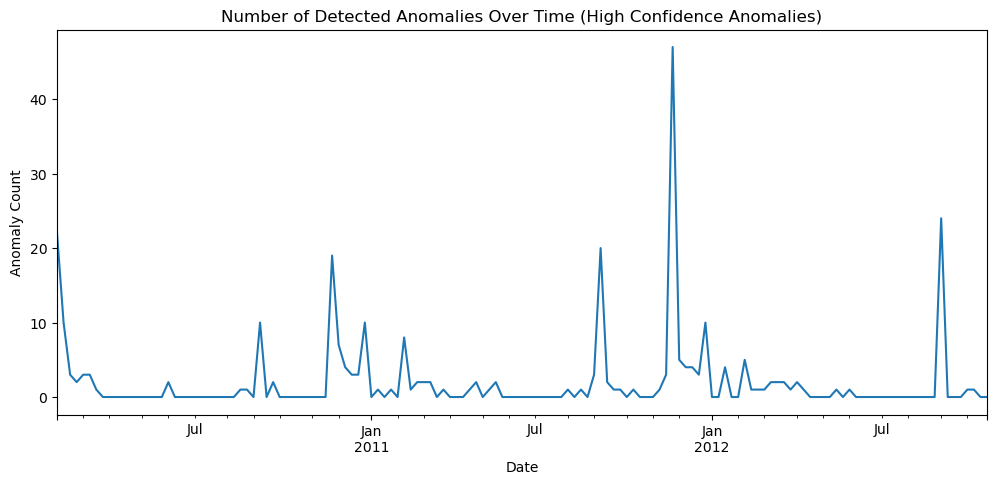

In [51]:
# Anomalies over time

anomalies_over_time = (
    df.groupby("Date")["High_Confidence_Anomaly"].sum()
)

plt.figure(figsize=(12,5))
anomalies_over_time.plot()
plt.title("Number of Detected Anomalies Over Time (High Confidence Anomalies)")
plt.ylabel("Anomaly Count")
plt.xlabel("Date")
plt.show()


In [54]:
# Do anomaly rates differ between holiday and non-holiday weeks?

df.groupby("IsHoliday")["High_Confidence_Anomaly"].mean()

IsHoliday
0    0.000316
1    0.005495
Name: High_Confidence_Anomaly, dtype: float64

Higher anomaly rate can be seen for Holiday weeks compared to non-holiday weeks. This suggests that the holiday season introduces more volatility and unusual sales patterns.

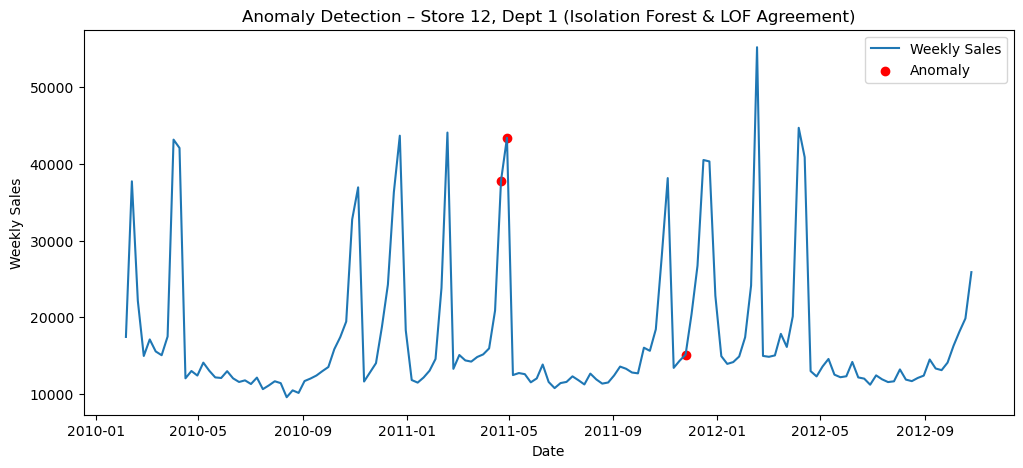

In [48]:
# Detailed Analysis of Anomalies in Store 12, Dept 1 based on both models agreement (High Confidence Anomalies)

sample = df[(df["Store"] == 12) & (df["Dept"] == 1)]

plt.figure(figsize=(12,5))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Weekly Sales")

anoms = sample[sample["High_Confidence_Anomaly"] == 1]
plt.scatter(
    anoms["Date"],
    anoms["Weekly_Sales"],
    color="red",
    label="Anomaly"
)

plt.title("Anomaly Detection – Store 12, Dept 1 (Isolation Forest & LOF Agreement)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


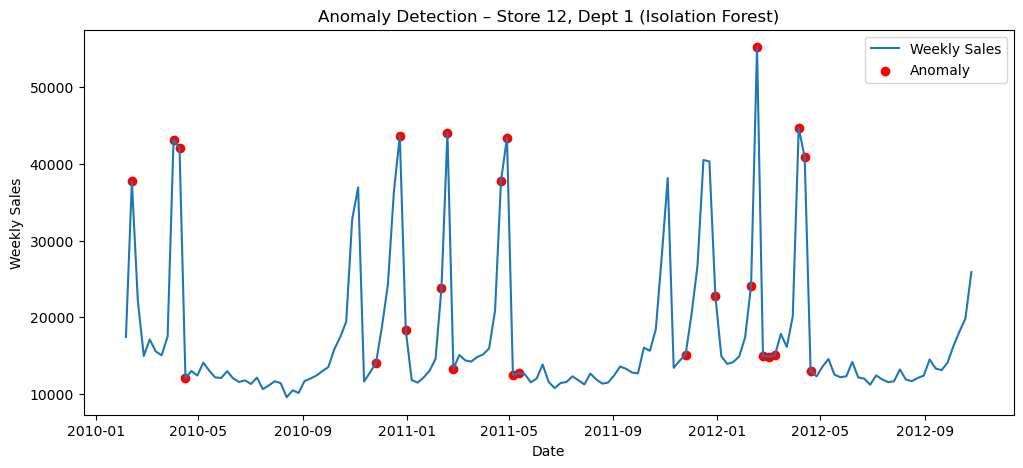

In [49]:
# Detailed Analysis of Anomalies in Store 12, Dept 1 based on Isolation Forest only
sample = df[(df["Store"] == 12) & (df["Dept"] == 1)]
plt.figure(figsize=(12,5))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Weekly Sales")
anoms = sample[sample["IF_Anomaly"] == 1]
plt.scatter(
    anoms["Date"],
    anoms["Weekly_Sales"],
    color="red",
    label="Anomaly"
)
plt.title("Anomaly Detection – Store 12, Dept 1 (Isolation Forest)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


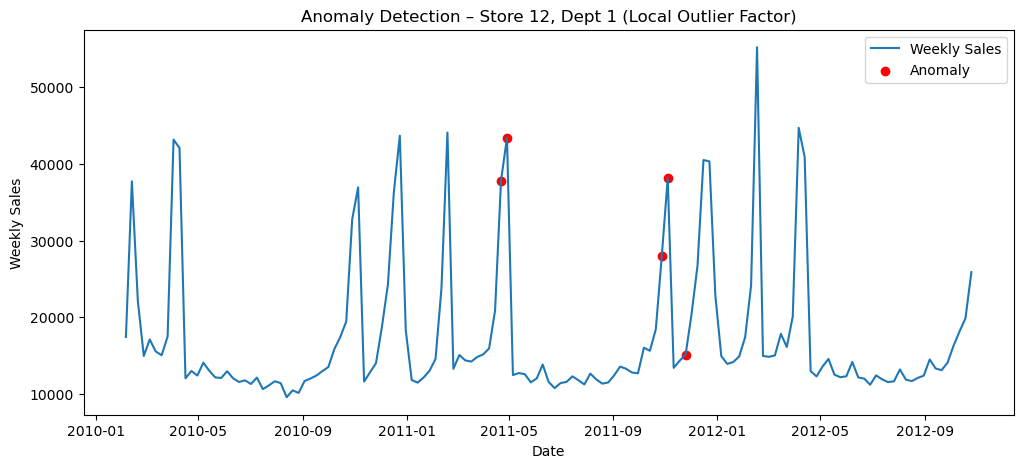

In [50]:
# Detailed Analysis of Anomalies in Store 12, Dept 1 based on LocalOutlierFactor only
sample = df[(df["Store"] == 12) & (df["Dept"] == 1)]
plt.figure(figsize=(12,5))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Weekly Sales")
anoms = sample[sample["LOF_Anomaly"] == 1]
plt.scatter(
    anoms["Date"],
    anoms["Weekly_Sales"],
    color="red",
    label="Anomaly"
)
plt.title("Anomaly Detection – Store 12, Dept 1 (Local Outlier Factor)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

In [47]:
df.to_parquet("processed_data/final_with_anomalies.parquet", index=False)